# Multiple-objective portfolio optimization

# INTRODUCTION

Your task is to solve a multiple-objective portfolio optimization problem.
-  Use the basic Markowitz's model from 1952 (see Lecture 1)
-  Solve = construct Pareto front approximations.
-  The dataset is the same as for the portfolio game part 1 (bundle1.zip).
-  The dataset consists of the historical prices of 20 assets.
-  The bundle contains 20 files (*.txt) linked to different assets.
-  The name of the file suggests the asset's name.
-  The structure of every file is as follows:
1.  The first line contains the name of the asset.
2. The second line provides the number of data points N.
3. The following N lines are data points with the structure: time, price.
-  The historical timeline for all assets is time $\in$ [0,100].
-  Future predictions should be calculated for time = 200.

Goal: 
-  Load data, make predictions, and build the model. 
-  Illustrate your predictions (can be done in the jupyter notebook)
-  Then, implement the WSM and ECM methods (see the tutorial on quadratic programming provided below). 
-  Run your implementations for different calculation limits (e.g., the number of weight vectors for WSM). Compare the methods' efficiency in finding unique Pareto optimal solutions. Finally, illustrate generated Pareto fronts.

Loaded 20 assets:
1. ABCDE
2. Apples
3. BetterTechnology
4. BetterTomorrow
5. CPU-XYZ
6. Electronics123
7. EnviroLike
8. Fuel4
9. Lasers
10. MarsProject
11. Moneymakers
12. PearPear
13. Photons
14. PositiveCorrelation
15. RoboticsX
16. SafeAndCare
17. SpaceNow
18. SuperFuture
19. WaterForce
20. WorldNow

Expected Returns:
                  Asset  Expected Return
4               CPU-XYZ         4.281729
0                 ABCDE         3.894678
16             SpaceNow         1.866038
19             WorldNow         1.793781
3        BetterTomorrow         0.283138
12              Photons         0.006315
6            EnviroLike        -0.332196
15          SafeAndCare        -0.355535
7                 Fuel4        -0.533787
18           WaterForce        -0.897272
8                Lasers        -0.999165
5        Electronics123        -1.173492
9           MarsProject        -1.298690
13  PositiveCorrelation        -1.831484
10          Moneymakers        -1.971389
2      BetterTechnol

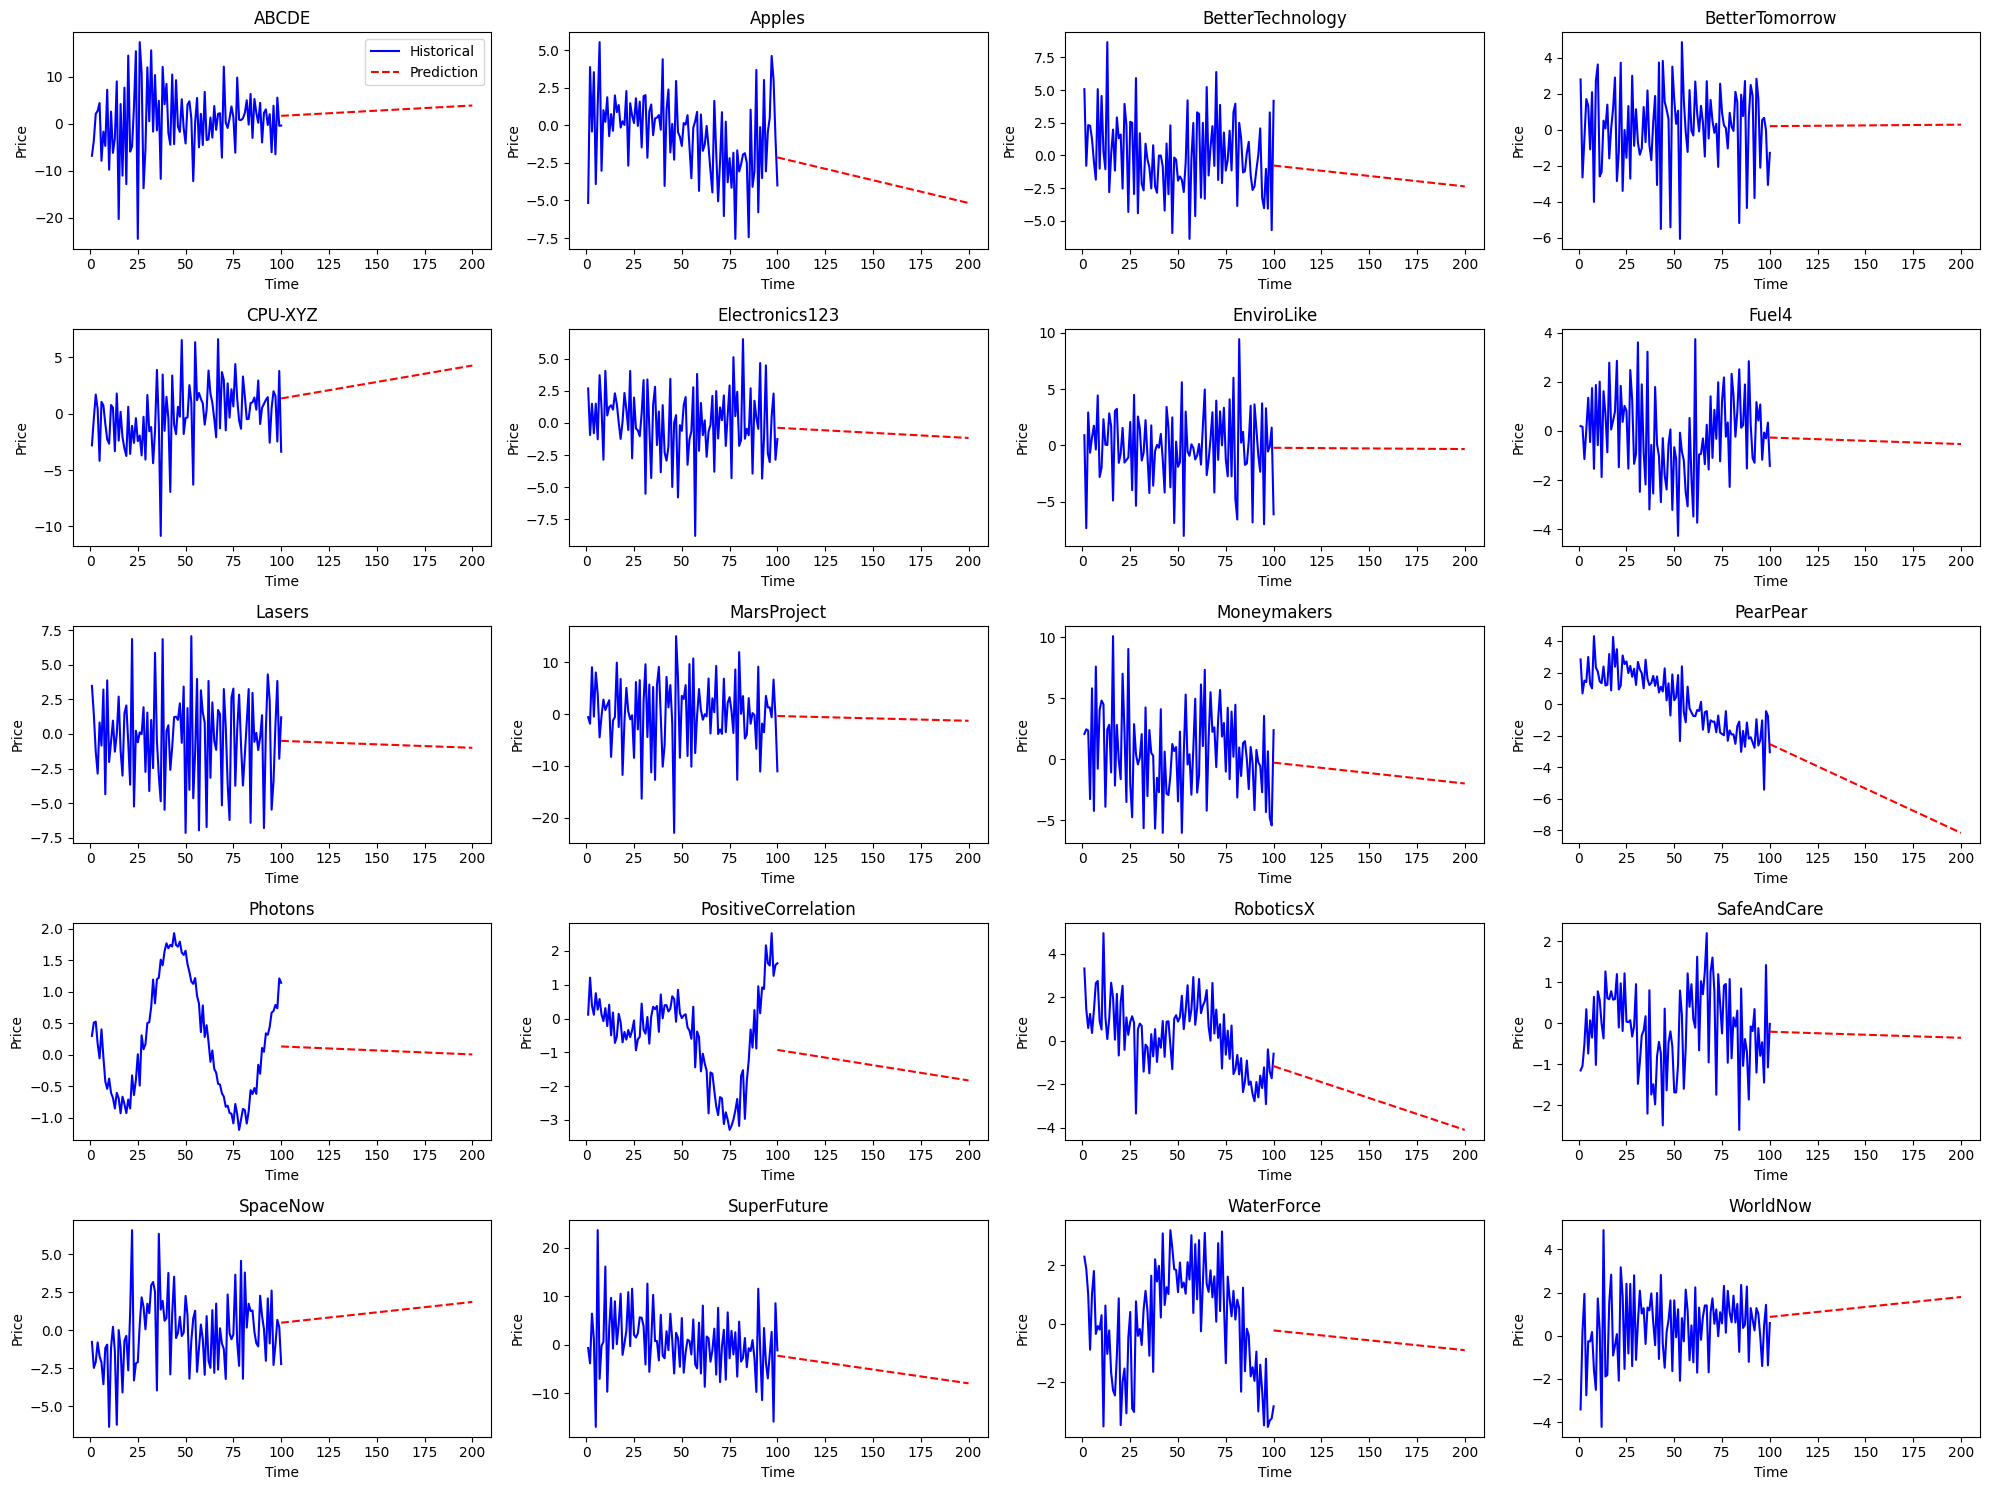


Running methods with 10 points:


ECM Progress: 100%|██████████| 10/10 [00:00<00:00, 137.01it/s]



Running methods with 50 points:


ECM Progress: 100%|██████████| 50/50 [00:00<00:00, 169.49it/s]



Running methods with 100 points:


ECM Progress: 100%|██████████| 100/100 [00:00<00:00, 166.95it/s]



Method Comparison:
   n_points  wsm_total  wsm_unique  ecm_total  ecm_unique  wsm_min_risk  \
0        10         10           9         10          10       0.31079   
1        50         50          44         50          50       0.31079   
2       100        100          88        100         100       0.31079   

   ecm_min_risk  wsm_max_return  ecm_max_return  
0       0.31079        4.281729        4.281729  
1       0.31079        4.281729        4.281729  
2       0.31079        4.281729        4.281729  


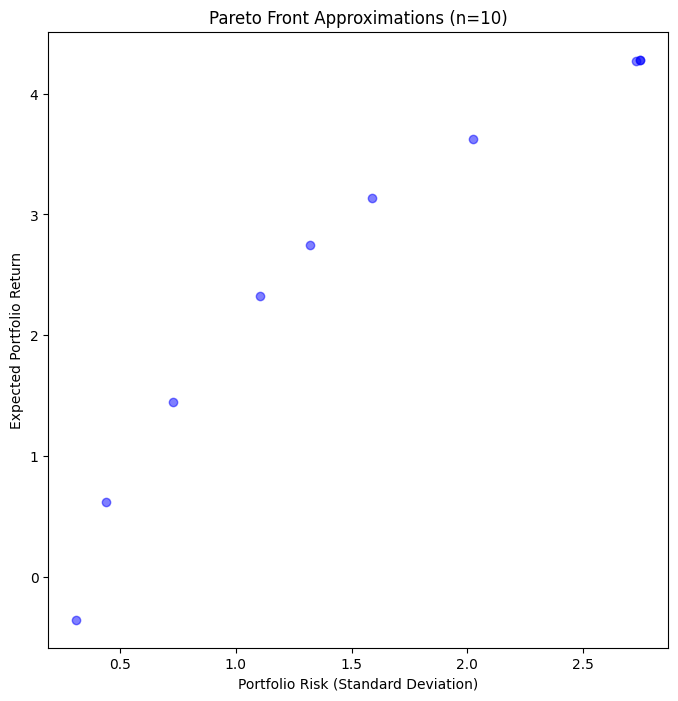

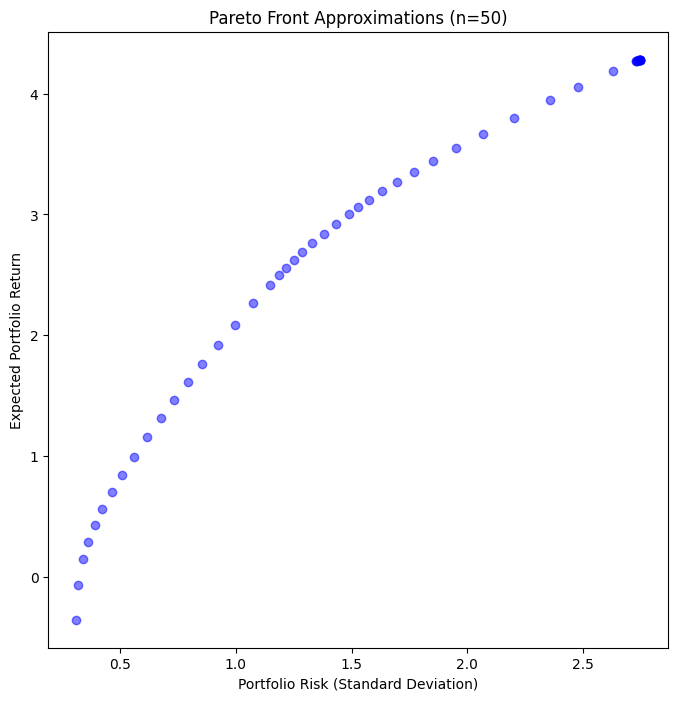

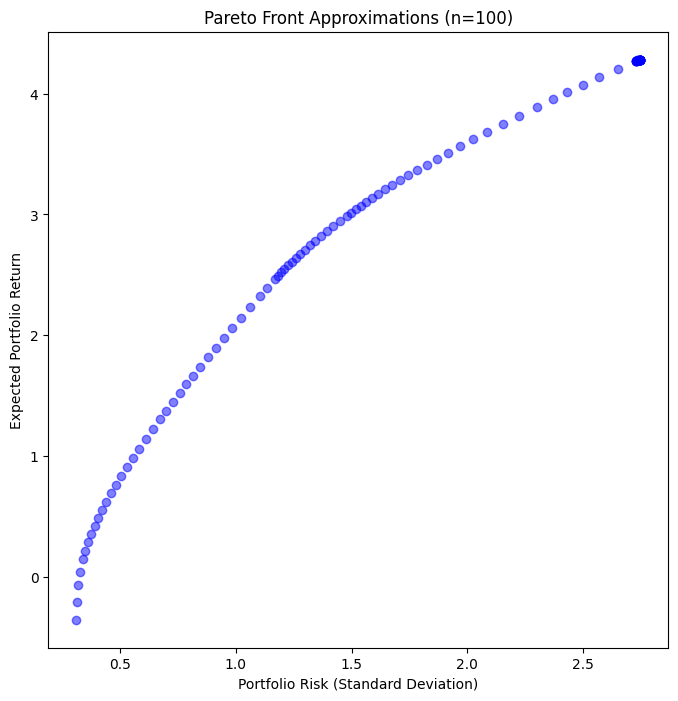

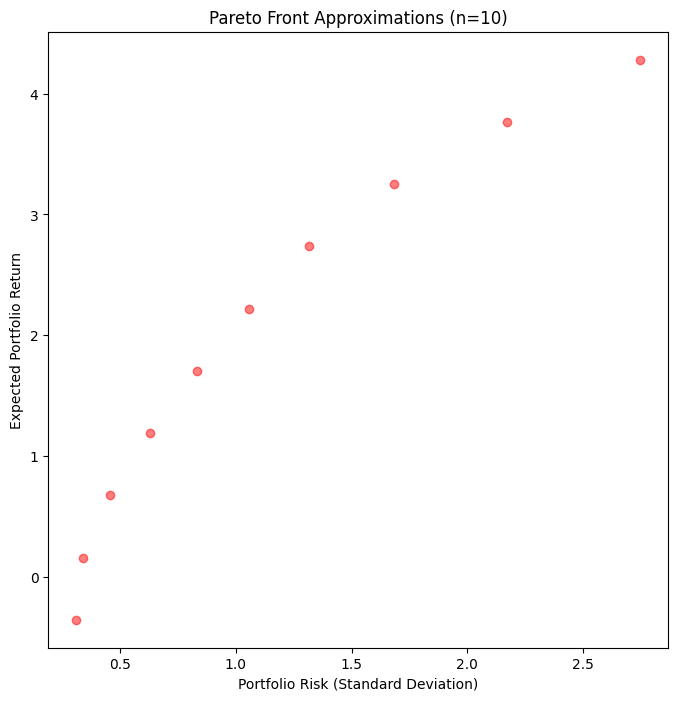

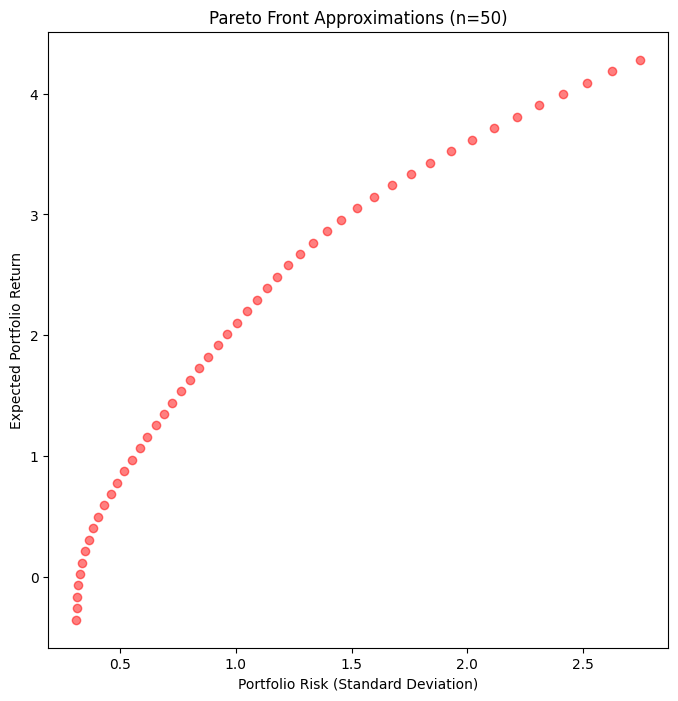

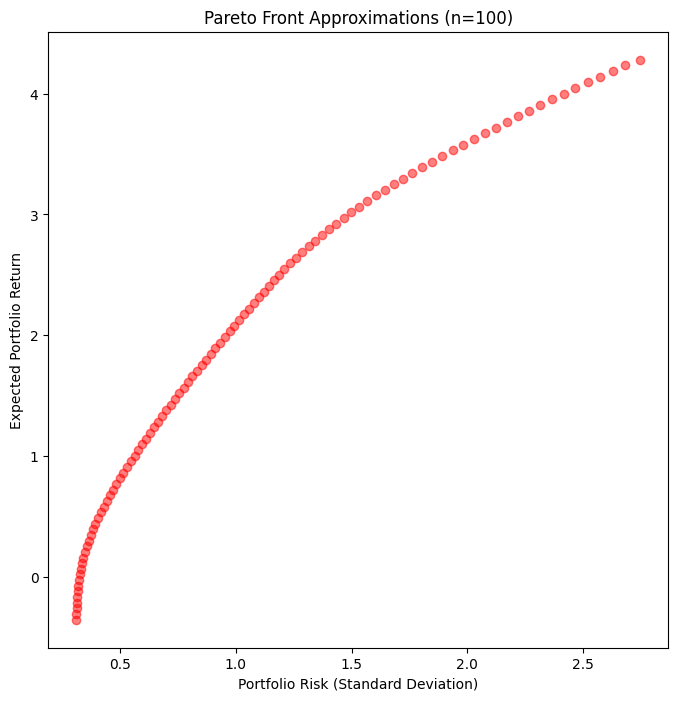

In [30]:

import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import pandas as pd
from sklearn.linear_model import LinearRegression


solvers.options['show_progress'] = False

def load_asset_data(file_path):
    """Load asset data from the given file path."""
    with open(file_path, 'r') as f:
        lines = f.readlines()
        
    asset_name = lines[0].strip()
    n_points = int(lines[1].strip())
    
    times = []
    prices = []
    
    for i in range(2, 2 + n_points):
        t, p = map(float, lines[i].strip().split())
        times.append(t)
        prices.append(p)
    
    return asset_name, np.array(times), np.array(prices)

def load_all_assets(directory_path):
    """Load all asset data from the given directory."""
    asset_files = glob.glob(os.path.join(directory_path, "*.txt"))
    assets = {}
    
    for file_path in asset_files:
        asset_name, times, prices = load_asset_data(file_path)
        assets[asset_name] = {'times': times, 'prices': prices}
    
    return assets

# Assuming the data files are in a directory called 'bundle1'
data_directory = './data/bundle1'  # Update this to match your data directory
assets = load_all_assets(data_directory)

# Print the assets we've loaded
print(f"Loaded {len(assets)} assets:")
for i, asset_name in enumerate(assets.keys()):
    print(f"{i+1}. {asset_name}")

# Step 2: Make predictions for time = 200
def linear_prediction(times, prices, target_time=200):
    """Make a linear prediction for the given asset at the target time."""
    model = LinearRegression()
    times_reshaped = times.reshape(-1, 1)
    model.fit(times_reshaped, prices)
    
    return model.predict([[target_time]])[0]

# Compute expected returns for each asset
def compute_returns(assets, target_time=200):
    """Compute expected returns for all assets."""
    expected_returns = {}
    
    for asset_name, data in assets.items():
        times = data['times']
        prices = data['prices']
        prices=[np.log(prices[x]/prices[x-1])*100 for x in range(1,len(prices))]
        times=times[1:]
        current_price = prices[-1]  # Price at time=100
        predicted_price = linear_prediction(times, prices, target_time)
        
        # Calculate expected return
        expected_return = predicted_price
        expected_returns[asset_name] = expected_return
    
    return expected_returns

expected_returns = compute_returns(assets)

# Display the expected returns
returns_df = pd.DataFrame({'Asset': list(expected_returns.keys()), 
                          'Expected Return': list(expected_returns.values())})
returns_df.sort_values('Expected Return', ascending=False, inplace=True)

print("\nExpected Returns:")
print(returns_df)

# Compute the covariance matrix
def compute_covariance_matrix(assets):
    """Compute the covariance matrix of asset returns."""
    # Extract asset names
    asset_names = list(assets.keys())
    n_assets = len(asset_names)
    
    # Calculate daily returns for each asset
    returns = {}
    for asset_name, data in assets.items():
        prices = data['prices']
        prices=[np.log(prices[x]/prices[x-1])*100 for x in range(1,len(prices))]
        # Calculate daily returns: (P_t - P_{t-1}) / P_{t-1}
        daily_returns = prices
        returns[asset_name] = daily_returns
    
    # Ensure all returns have the same length
    min_length = min(len(returns[asset]) for asset in asset_names)
    for asset in asset_names:
        returns[asset] = returns[asset][-min_length:]
    
    # Create a matrix of returns
    returns_matrix = np.array([returns[asset] for asset in asset_names])
    
    # Compute the covariance matrix
    cov_matrix = np.cov(returns_matrix)
    
    return cov_matrix, asset_names

cov_matrix, asset_names = compute_covariance_matrix(assets)

print("\nCovariance Matrix Shape:", cov_matrix.shape)
print("Asset Names:", asset_names)

# Step 3: Illustrate predictions
plt.figure(figsize=(20, 15))

for i, (asset_name, data) in enumerate(assets.items()):
    times = data['times']
    prices = data['prices']
    times=times[1:]
    prices=[np.log(prices[x]/prices[x-1])*100 for x in range(1,len(prices))]
    # Make prediction
    model = LinearRegression()
    times_reshaped = times.reshape(-1, 1)
    model.fit(times_reshaped, prices)
    
    # Generate prediction line
    pred_times = np.array([times[-1], 200])
    pred_prices = model.predict(pred_times.reshape(-1, 1))
    
    plt.subplot(5, 4, i+1)
    plt.plot(times, prices, 'b-', label='Historical')
    plt.plot(pred_times, pred_prices, 'r--', label='Prediction')
    plt.title(asset_name)
    plt.xlabel('Time')
    plt.ylabel('Price')
    
    if i == 0:  # Only show legend for the first plot
        plt.legend()

plt.tight_layout()
plt.savefig('asset_predictions.png')
plt.show()

# Step 4: Portfolio Optimization Functions

def optimize_portfolio(expected_returns, cov_matrix, asset_names, target_return=None):
    """
    Optimize portfolio weights to minimize risk for a given return.
    If target_return is None, find the minimum risk portfolio.
    """
    n_assets = len(asset_names)
    
    # Convert expected returns to a numpy array
    mu = np.array([expected_returns[asset] for asset in asset_names])
    
    # Prepare matrices for CVXOPT
    P = matrix(cov_matrix)
    q = matrix(np.zeros(n_assets))
    
    # Constraint: sum of weights = 1
    A = matrix(np.ones((1, n_assets)))
    b = matrix(1.0)
    
    # Constraint: x_i >= 0 (no short selling)
    G = matrix(-np.eye(n_assets))
    h = matrix(np.zeros(n_assets))
    
    # If target return is specified, add that constraint
    if target_return is not None:
        # Add a constraint for the target return
        A_new = matrix(np.vstack((np.ones(n_assets), mu)))
        b_new = matrix([1.0, target_return])
        A = A_new
        b = b_new
    
    # Solve the quadratic programming problem
    solution = solvers.qp(P, q, G, h, A, b)
    
    # Extract the optimal weights
    weights = np.array(solution['x']).flatten()
    
    # Calculate portfolio return and risk
    portfolio_return = np.dot(weights, mu)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    return weights, portfolio_return, portfolio_risk

# Step 5: Implement WSM (Weighted Sum Method)
def wsm_method(expected_returns, cov_matrix, asset_names, n_points=100):
    """
    Implement the Weighted Sum Method to generate Pareto front approximations.
    """
    # Initialize arrays to store results
    returns = []
    risks = []
    all_weights = []
    
    # Generate weight vectors for WSM
    lambdas = np.linspace(0, 1, n_points)
    
    for lambd in tqdm(lambdas, desc="WSM Progress"):
        # Create a combined objective: minimize (lambda * risk - (1-lambda) * return)
        # For CVXOPT: min c*x + 0.5*x'*P*x
       
        P = matrix((1-lambd)*cov_matrix)
        c = matrix(-lambd * np.array([expected_returns[asset] for asset in asset_names]))
  
        # Constraints
        A = matrix(np.ones((1, len(asset_names))))
        b = matrix(1.0)
        G = matrix(-np.eye(len(asset_names)))
        h = matrix(np.zeros(len(asset_names)))
        
        # Solve
        solution = solvers.qp(P, c, G, h, A, b)
        
        # Extract results
        weights = np.array(solution['x']).flatten()
      
        portfolio_return = np.dot(weights, [expected_returns[asset] for asset in asset_names])
        portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        returns.append(portfolio_return)
        risks.append(portfolio_risk)
        all_weights.append(weights)
    
    return np.array(risks), np.array(returns), np.array(all_weights)

# Step 6: Implement ECM (Epsilon Constraint Method)
def ecm_method(expected_returns, cov_matrix, asset_names, n_points=100):
    """
    Implement the Epsilon Constraint Method to generate Pareto front approximations.
    """
    # Initialize arrays to store results
    returns = []
    risks = []
    all_weights = []
    
    # Find the maximum return portfolio
    mu = np.array([expected_returns[asset] for asset in asset_names])
    max_return_idx = np.argmax(mu)
    max_return = mu[max_return_idx]
    
    # Find the minimum risk portfolio
    weights_min_risk, min_return, min_risk = optimize_portfolio(expected_returns, cov_matrix, asset_names)
    
    # Generate return levels for ECM
    return_levels = np.linspace(min_return, max_return, n_points)
    
    for target_return in tqdm(return_levels, desc="ECM Progress"):
        try:
            weights, actual_return, risk = optimize_portfolio(
                expected_returns, cov_matrix, asset_names, target_return
            )
            
            returns.append(actual_return)
            risks.append(risk)
            all_weights.append(weights)
        except Exception as e:
            # Skip infeasible solutions
            print(f"Skipping infeasible return level: {target_return}, Error: {e}")
            continue
    
    return np.array(risks), np.array(returns), np.array(all_weights)

# Step 7: Run the methods with different calculation limits
n_points_list = [10,50,100]

results = {}

for n_points in n_points_list:
    print(f"\nRunning methods with {n_points} points:")
    
    # Run WSM
    wsm_risks, wsm_returns, wsm_weights = wsm_method(
        expected_returns, cov_matrix, asset_names, n_points
    )
    
    # Run ECM
    ecm_risks, ecm_returns, ecm_weights = ecm_method(
        expected_returns, cov_matrix, asset_names, n_points
    )
    
    results[n_points] = {
        'wsm': {'risks': wsm_risks, 'returns': wsm_returns, 'weights': wsm_weights},
        'ecm': {'risks': ecm_risks, 'returns': ecm_returns, 'weights': ecm_weights}
    }

# Step 8: Compare methods' efficiency
def filter_unique_solutions(risks, returns, tolerance=1e-4):
    """Filter out duplicate solutions."""
    points = np.column_stack((risks, returns))
    unique_points = []
    
    for point in points:
        is_unique = True
        for unique_point in unique_points:
            if np.all(np.abs(point - unique_point) < tolerance):
                is_unique = False
                break
        
        if is_unique:
            unique_points.append(point)
    
    return np.array(unique_points)

comparison_results = []

for n_points, result in results.items():
    wsm_unique = filter_unique_solutions(result['wsm']['risks'], result['wsm']['returns'])
    ecm_unique = filter_unique_solutions(result['ecm']['risks'], result['ecm']['returns'])
    
    comparison_results.append({
        'n_points': n_points,
        'wsm_total': len(result['wsm']['risks']),
        'wsm_unique': len(wsm_unique),
        'ecm_total': len(result['ecm']['risks']),
        'ecm_unique': len(ecm_unique),
        'wsm_min_risk': np.min(result['wsm']['risks']),
        'ecm_min_risk': np.min(result['ecm']['risks']),
        'wsm_max_return': np.max(result['wsm']['returns']),
        'ecm_max_return': np.max(result['ecm']['returns'])
    })

comparison_df = pd.DataFrame(comparison_results)
print("\nMethod Comparison:")
print(comparison_df)

# Step 9: Illustrate Pareto fronts


for i, n_points in enumerate(n_points_list):
    plt.figure(figsize=(8, 8))
    
    result = results[n_points]
    
    plt.scatter(result['wsm']['risks'], result['wsm']['returns'], 
                c='blue', alpha=0.5, label=f'WSM ({n_points} points)')
    plt.xlabel('Portfolio Risk (Standard Deviation)')
    plt.ylabel('Expected Portfolio Return')
    plt.title(f'Pareto Front Approximations (n={n_points})')
    plt.show()


for i, n_points in enumerate(n_points_list):
   
    plt.figure(figsize=(8,8))
    result = results[n_points]

    plt.scatter(result['ecm']['risks'], result['ecm']['returns'], 
                c='red', alpha=0.5, label=f'ECM ({n_points} points)')
    
    plt.xlabel('Portfolio Risk (Standard Deviation)')
    plt.ylabel('Expected Portfolio Return')
    plt.title(f'Pareto Front Approximations (n={n_points})')
    plt.show()

In [31]:
results

{10: {'wsm': {'risks': array([0.31078963, 0.44001766, 0.7277488 , 1.10287329, 1.31985108,
          1.58824725, 2.02587982, 2.72703682, 2.74524913, 2.74525071]),
   'returns': array([-0.35772859,  0.62023624,  1.44732243,  2.3232292 ,  2.74503942,
           3.13713313,  3.62379765,  4.27198629,  4.28172856,  4.28172905]),
   'weights': array([[3.40818056e-03, 8.27654035e-08, 2.33086316e-02, 4.01461463e-03,
           3.08026219e-02, 4.66658338e-02, 9.40701779e-03, 1.06770933e-01,
           6.59502732e-10, 5.20334658e-03, 7.28669058e-03, 1.98216640e-09,
           2.54621088e-01, 1.04353520e-01, 2.29503830e-02, 2.65711659e-01,
           3.13688549e-02, 2.55090146e-04, 5.26798005e-02, 3.11916477e-02],
          [6.03708463e-03, 3.52400974e-10, 2.36192687e-08, 4.94931299e-02,
           1.00860980e-01, 3.60268400e-02, 6.45934900e-03, 6.68542356e-02,
           1.90234042e-09, 1.59447810e-03, 5.96168544e-08, 2.51198594e-10,
           3.17524947e-01, 2.31716087e-09, 9.54565974e-10, 2.40

# Short tutorial on the cvxopt library for quadratic programming

In [ ]:
import numpy as np
from cvxopt import matrix, solvers

# QP Optimization Problem

### General model:

$max$ $\boldsymbol{cx} - \dfrac{1}{2}\boldsymbol{x}^T\boldsymbol{Qx}$ <br>
$s.t.$ <br>
$\boldsymbol{Gx} \leq \boldsymbol{h}$ <br>
$\boldsymbol{x} \geq \boldsymbol{0}$

### But the library uses the following form:

$min$ $\boldsymbol{cx} + \dfrac{1}{2}\boldsymbol{x}^T\boldsymbol{Qx}$ <br>
$s.t.$ <br>
$\boldsymbol{Gx} \leq \boldsymbol{h}$ <br>
$\boldsymbol{Ax} = \boldsymbol{b}$ <br>

### Exmple

$min$ $2x^2_1+x_2^2+x_1x_2+x_1+x_2$ <br>
$s.t.$ <br>
$x_1 \geq 0$<br>
$x_2 \geq 0$<br>
$x_1 + x_2 = 1$<br>

### Hence:

In [8]:
Q = matrix([ [4.0, 1.0], [1.0, 2.0] ]) ## [4, 1] is 1st column, not row!

In [9]:
c = matrix([1.0, 1.0]) ### (1, 2) = dimensions (1 row and 2 columns)

In [10]:
A = matrix([1.0, 1.0], (1,2)) ### (1, 2) = dimensions (1 row and 2 columns)

In [11]:
b = matrix(1.0) 

In [12]:
G = matrix([[-1.0,0.0],[0.0,-1.0]]) ### multiplied both sides by -1

In [13]:
h = matrix([0.0,0.0]) ### multiplied both sides by -1

In [14]:
solQP=solvers.qp(Q, c, G, h, A, b)

In [15]:
print(solQP.keys())

dict_keys(['x', 'y', 's', 'z', 'status', 'gap', 'relative gap', 'primal objective', 'dual objective', 'primal infeasibility', 'dual infeasibility', 'primal slack', 'dual slack', 'iterations'])


In [16]:
print(solQP['x'])
print(solQP['primal objective'])

[ 2.50e-01]
[ 7.50e-01]

1.875000000000018


# We can also solve LP problems:

$min$ $\boldsymbol{c}\boldsymbol{x}$ <br>
$s.t.$ <br>
$\boldsymbol{Gx} \leq \boldsymbol{h}$ <br>
$\boldsymbol{Ax} = \boldsymbol{b}$ (optional)

### Exmple

$min$ $2x_1+x_2$ <br>
$s.t.$ <br>
$-x_1 +x_2 \leq 1$ <br>
$x_1 + x_2 \geq 2$ <br>
$x_2 \geq 0$<br>
$x_1 - 2x_2 \leq 4$

In [17]:
G = matrix([ [-1.0, -1.0, 0.0, 1.0], [1.0, -1.0, -1.0, -2.0] ])
h = matrix([ 1.0, -2.0, 0.0, 4.0 ])
c = matrix([ 2.0, 1.0 ])
solLP = solvers.lp(c,G,h)  
###!!!! OPTIONALLY A and b can be provided (equality constraints) as in solQP=solvers.qp(Q, c, G, h, A, b)

In [18]:
print(solLP.keys())

dict_keys(['x', 'y', 's', 'z', 'status', 'gap', 'relative gap', 'primal objective', 'dual objective', 'primal infeasibility', 'dual infeasibility', 'primal slack', 'dual slack', 'residual as primal infeasibility certificate', 'residual as dual infeasibility certificate', 'iterations'])


In [19]:
print(solLP['x'])
print(solLP['primal objective'])

[ 5.00e-01]
[ 1.50e+00]

2.4999999895543077


# Portfolio optimization

In [20]:
### SOLVE HERE